In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import host_subplot
import scipy.stats
import pickle
import string
import astropy
from astropy import units as u
#from yt import units as u
from astropy.coordinates import SkyCoord 
from astropy.coordinates import Galactic
from astropy.coordinates import Angle, Latitude, Longitude
from astropy.constants import c
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Polygon
from cycler import cycler
import numpy as np
import copy
from fractions import Fraction
#plt.rcParams['xtick.top'] = True
#plt.rcParams['ytick.right'] = True
import rm_tools
from rm_tools import RMSynth, RMClean
import spectral_cube
from spectral_cube import SpectralCube
#import rmsynthesis

In [16]:
plt.rcParams['text.usetex'] = False

In [2]:
def piformat(x,pos):
    frac = Fraction(x/np.pi)
    if frac.denominator == 1:
        if frac.numerator == 0:
            return '$0$'
        if frac.numerator == 1:
            return '$\pi$'
        if frac.numerator == -1:
            return '$-\pi$'
        return '$' + '{:g}'.format(frac.numerator) + '\pi$'
    if frac.numerator == 1:
        return '$\pi / ' + '{:g}'.format(frac.denominator) + '$'
    if frac.numerator == -1:
        return '$-\pi / ' + '{:g}'.format(frac.denominator) + '$'
    return '$' + '{:g}'.format(frac.numerator) + '\pi / ' + '{:g}'.format(frac.denominator) + '$'

In [3]:
def calc_RM_spectrum(nu, P, phi, cutoff=0.02, niter=1000, gain=0.1, weights=None, verbose=False):
    wlen = (nu*u.Hz).to(u.m, equivalencies=u.spectral())
    dlsq = wlen[1]**2 - wlen[0]**2
    maxscale = np.pi / np.min(wlen**2)
    maxphi = 1 / dlsq
    dphi = 1 / (np.max(wlen)**2 - np.min(wlen)**2)
    if verbose:
        print('max scale = {:.2f}. max phi = {:.2f}. dphi = {:.2f}'.format(maxscale, maxphi, dphi))
    rmsynth = RMSynth(nu, nu[1]-nu[0], phi, weights=weights)
    dirty_image = rmsynth.compute_dirty_image(P)
    rmclean = RMClean(rmsynth, cutoff=cutoff, niter=niter, gain=gain)
    rmclean.perform_clean(P)
    cleaned = rmclean.restore_clean_map()
    return rmsynth, rmclean

In [4]:
xi=45*u.deg

In [5]:
def calc_sightline_emis(l, b=0*u.deg, pitch=11.5*u.deg, b0=8.0*u.G/5.0,
                        emisnorm=1.0*u.K/u.kpc,h_rcre=5.0*u.kpc,h_zcre=1.0*u.kpc, ncells=100,
                        pathlen=1.0*u.kpc, xi=0*u.deg):
    dist = np.arange(0, pathlen.to(u.kpc).value, pathlen.to(u.kpc).value/ncells) * u.kpc
    n_cre = np.ones(ncells)
    btot = b0
    blos = -np.sin(xi) * btot
    emis = emisnorm * n_cre * (btot * np.cos(xi) )**2/u.uG**2   # K / kpc
#    synch = emisnorm*n_cre*((b0/rgc)*np.cos(np.deg2rad(xi_sl)))**2 * (dist[1]-dist[0])
    return emis, n_cre, dist, blos

In [6]:
K = 0.81 * (u.cm**-3 * u.uG * u.pc)**-1 * u.radian * u.m**-2
K

<Quantity 0.81 cm3 rad / (m2 pc uG)>

In [7]:
sign = 0.3 * np.log(10) # convert base 10 sigma to base e sigma
nx = 25
inputs = []

narm = 1.0*u.cm**-3
chars_gen = (a for a in string.ascii_lowercase)

ncells = 1000

#emis, xi_sl, n_cre, sl, breg_los = calc_sightline_emis(180*u.deg, pitch=0.0*u.deg, ncells=ncells, b0=12*u.uG,
#                                                       emisnorm=1.0*u.K/(1000.0*u.pc), h_rcre=5*u.Mpc)

btot = 1*u.uG
emis = np.ones(ncells) * 1.0*u.K / (1000*u.pc)
n_cre = np.ones(ncells) * u.cm**-3
pathlen=8*u.kpc
dist = (np.arange(0, pathlen.to(u.kpc).value, pathlen.to(u.kpc).value/ncells) * u.kpc).to(u.pc)

n1 = 0.022*u.cm**(-3)/1.4
# numpy lognormal function uses natural log
mu = np.log(n1.to(u.cm**-3).value)

In [8]:
#GMIMS frequency range
#maxl = ((1.3*u.GHz).to(u.m, equivalencies=u.spectral())).value
#minl = ((1.8*u.GHz).to(u.m, equivalencies=u.spectral())).value
#nwaves = 100
#wlen = np.arange(minl, maxl, (maxl-minl)/nwaves)*u.m

#maxl = 0.8
#minl = 0.1
#wlen = np.arange(minl, maxl, (maxl-minl)/nwaves)*u.m

#nu = np.arange(300,1800,1)*u.MHz
#wlen = nu.to(u.m,equivalencies=u.spectral())

nu = np.arange(300,1800,0.5)
nu = np.append(nu, np.arange(2000,23050,1000))*u.MHz
wlen = nu.to(u.m,equivalencies=u.spectral())

nwaves = len(wlen)

baseinput = {'B0': btot, 'fillfrac': 0.5, 'wlen': wlen, 'nx': nx, 'sign': sign,
             'mu': mu, 'foregroundemis': 0.0*u.K/u.pc, 'symbol': '.', 'minz': 0.0*u.pc, 'nz': ncells,
             'dz': dist[1]-dist[0], 'zarm': 5000*u.pc, 'emis': emis, 'psi0': 10.0*u.deg,
             'widarm': 100.0*u.pc, 'beta': 3.2, 'z': dist}

name = 'noarm'
inputs.append(baseinput.copy())
inputs[-1]['sigB'] = 3.0*u.uG
inputs[-1]['narm'] = 0.0*u.cm**-3
inputs[-1]['name'] = name
inputs[-1]['Barm'] = 0.0*u.uG
inputs[-1]['sigBarm'] = 0.0*u.uG

name = 'arm_5kpc'
inputs.append(baseinput.copy())
inputs[-1]['sigB'] = 3.0*u.uG
inputs[-1]['narm'] = narm
inputs[-1]['name'] = name
inputs[-1]['Barm'] = 1.0*u.uG
inputs[-1]['sigBarm'] = 6.0*u.uG

name = 'HII_100pc'
inputs.append(baseinput.copy())
inputs[-1]['sigB'] = 3.0*u.uG
inputs[-1]['narm'] = narm
inputs[-1]['name'] = name
inputs[-1]['Barm'] = 1.0*u.uG
inputs[-1]['sigBarm'] = 6.0*u.uG
inputs[-1]['zarm'] = 100*u.pc
inputs[-1]['widarm'] = 10*u.pc
inputs[-1]['z'] = np.arange(0,3000,3000.0/ncells)*u.pc
inputs[-1]['dz'] = inputs[-1]['z'][1] - inputs[-1]['z'][0]


#name = 'arm_05_s2'
#inputs.append(baseinput.copy())
#inputs[-1]['sigB'] = 3.0*u.uG
#inputs[-1]['narm'] = narm*2
#inputs[-1]['name'] = name

In [9]:
def create_model(inp):
    nwaves=len(inp['wlen'])
    nx=inp['nx']
    nz=inp['nz']

    model = {}
    model['input'] = inp
    model['nearray'] = np.random.lognormal(inp['mu'], inp['sign'], size=(inp['nx'],inp['nz'])) * u.cm**-3 +\
            inp['narm'] * np.exp( -(inp['z']-inp['zarm'])**2 / (2.0*inp['widarm']**2) )
    model['nearray'][np.where(np.random.uniform(size=(nx, nz)) < inp['fillfrac'])] = 0.0
    model['Bzarray'] = np.random.normal(0, inp['sigB'].value, size=(inp['nx'],inp['nz']))*u.uG + inp['B0'] +\
            inp['Barm'] * np.exp( -(inp['z']-inp['zarm'])**2 / (2.0*inp['widarm']**2) ) * \
            np.random.normal(0, inp['sigBarm'].value, size=(inp['nx'],inp['nz']))

    model['dphi'] = K * inp['dz'] * model['nearray'] * model['Bzarray']
    model['phi'] = np.cumsum(model['dphi'], axis=1).to(u.rad/u.m**2)
    model['psi'] = model['phi'][:,:,np.newaxis] * inp['wlen']**2
    
    emisrep=np.repeat(np.repeat(inp['emis'], nx).reshape(nx, nz).T,
                      nwaves).reshape(nx, nz, nwaves)
    
    wlenbetarep=(np.repeat(np.repeat((inp['wlen']/(0.2*u.m))**inp['beta'],
                                 nz).reshape(nwaves, nz),nx).reshape(nwaves,nz,nx)).T
    
    model['P'] = (np.cumsum(emisrep * wlenbetarep * np.exp(2j*model['psi'].to(u.rad).value), axis=1) * inp['dz']).to(u.K)
    model['psiP'] = 0.5*np.arctan2(model['P'].imag, model['P'].real)
    
    model['Pbeam'] = np.sum(model['P'], axis=0)
    model['psiPbeam'] = 0.5*np.arctan2(model['Pbeam'].imag, model['Pbeam'].real)
    
    return model


In [11]:
%%time
models = [create_model(inp) for inp in inputs]

CPU times: user 47.6 s, sys: 24 s, total: 1min 11s
Wall time: 1min 17s


In [12]:
for m in models:
    if m['input']['narm'] > 0:
        zstr = '${:.0f}$'.format(m['input']['zarm'].to(u.pc).value)
        wstr = '${:.0f}$'.format(m['input']['widarm'].to(u.pc).value)
    else:
        zstr = '...'
        wstr = '...'
    DM = np.mean(((m['nearray']*m['input']['dz']).sum(axis=1)).to(u.pc*u.cm**-3))
    print('{{\\tt {:10}}} & ${:.3f}$ & ${:.2f}$ & ${:.1f}$ & ${:.1f}$ & {:6} & {:5} & ${:.1f}$ & ${:.1f}$ & ${:.1f}$ & ${:.0f}^\\circ$ & ${:.0f}$ \\\\'.format(m['input']['name'].replace('_', '\_'),
                                    np.exp(m['input']['mu']), m['input']['sign']/np.log(10), m['input']['fillfrac'],
                                    m['input']['narm'].value, zstr, wstr, DM.value,
                                    m['input']['B0'].value, m['input']['sigB'].value, xi.value, m['input']['nx']))

{\tt noarm     } & $0.016$ & $0.30$ & $0.5$ & $0.0$ & ...    & ...   & $79.8$ & $1.0$ & $3.0$ & $45^\circ$ & $25$ \\
{\tt arm\_5kpc } & $0.016$ & $0.30$ & $0.5$ & $1.0$ & $5000$ & $100$ & $198.9$ & $1.0$ & $3.0$ & $45^\circ$ & $25$ \\
{\tt HII\_100pc} & $0.016$ & $0.30$ & $0.5$ & $1.0$ & $100$  & $10$  & $44.1$ & $1.0$ & $3.0$ & $45^\circ$ & $25$ \\


In [13]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [14]:
np.mean(m['phi'], axis=0).shape

(1000,)

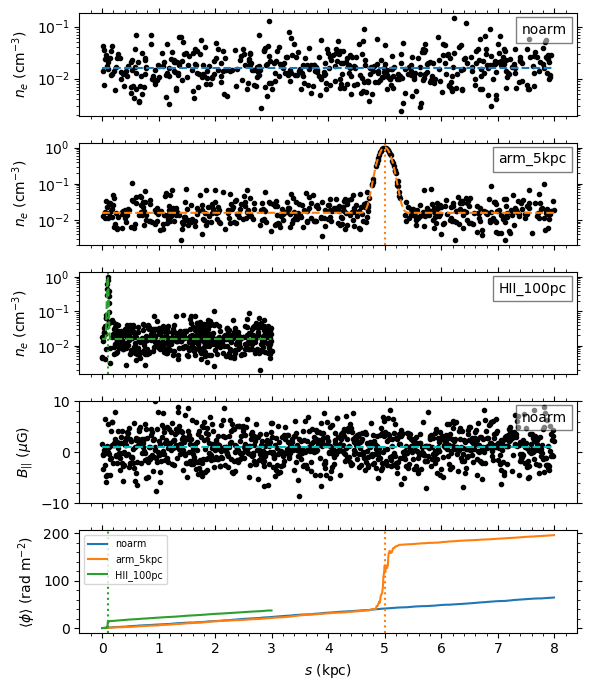

In [305]:
## REMINDER: this crashes if plt.rcParams['text.usetex'] is True

fig, axes = plt.subplots(nrows=len(models)+2, ncols=1, figsize=(6,7), sharex=True)

for i, m in enumerate(models):   
    p = axes[-1].plot(m['input']['z'].to(u.kpc), np.mean(m['phi'], axis=0), label=m['input']['name'])
    axes[-1].set_ylabel(r'$\langle \phi \rangle$ (rad m$^{-2}$)')
    axes[-1].legend(loc='upper left', fontsize='x-small')
    if m['input']['narm'] > 0:
        axes[-1].axvline(m['input']['zarm'].to(u.kpc).value, linestyle=':', color = p[0].get_color())

    axes[i].plot(m['input']['z'].to(u.kpc), m['nearray'][0], 'k.')
    meann = np.exp(m['input']['mu'])*u.cm**-3 + m['input']['narm'] * \
            np.exp( -(m['input']['z']-m['input']['zarm'])**2 / (2.0*m['input']['widarm']**2) )
    axes[i].plot(m['input']['z'].to(u.kpc), meann, '--', color=p[0].get_color())
    axes[i].set_yscale('log')
    axes[i].set_ylabel(r'$n_e$ (cm$^{-3}$)')
    axes[i].text(0.98,0.8,m['input']['name'], horizontalalignment='right',
                transform=axes[i].transAxes, bbox=dict(facecolor='white',alpha=0.5))

    if m['input']['narm'] > 0:
        axes[i].axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle=':', color=p[0].get_color())
    

m = models[0]
i=-2

#axes[-1].plot(m['input']['z'].to(u.kpc), m['phi'][0], 'k.', label=m['input']['name'])
#axes[-1].set_ylabel(r'$\langle \phi \rangle$ (rad m$^{-2}$)')
#axes[-1].legend(loc='best', fontsize='x-small')
#axes[-1].set_yscale('log')

axes[i].plot(m['input']['z'].to(u.kpc), m['Bzarray'][0], 'k.')
meanB = m['input']['B0'] +\
        m['input']['Barm'] * np.exp( -(m['input']['z']-m['input']['zarm'])**2 / (2.0*m['input']['widarm']**2) )

axes[i].plot(m['input']['z'].to(u.kpc), meanB, 'c--')
axes[i].set_ylabel(r'$B_{||}$ ($\mu$G)')
axes[i].set_ylim(-10,10)
axes[i].text(0.98,0.8,m['input']['name'], horizontalalignment='right',
                transform=axes[i].transAxes, bbox=dict(facecolor='white',alpha=0.5))

axes[-1].set_xlabel(r'$s$ (kpc)')
#axes[i].text(0.98,0.8,m['input']['name'], horizontalalignment='right',
#                transform=axes[i].transAxes, bbox=dict(facecolor='white',alpha=0.5))
#if m['input']['narm'] > 0:
#        axes[i].axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted')

fig.tight_layout()
fig.savefig('../figures/ne_B_prof_combined.pdf')

In [18]:
%%time
for m in models:
    print('model ' + m['input']['name'])
#    m['phimax_drao'] = np.zeros(m['input']['nz'])
#    m['phimax_drao'][:] = np.nan
#    m['phi_spectrum_drao'] = np.zeros(m['input']['nz'])
#    m['phimax_parkes'] = np.zeros(m['input']['nz'])
#    m['phimax_parkes'][:] = np.nan
    
    m['phi_parkes'] = np.arange(-300,300,1)
    m['cube_parkes'] = np.zeros((m['input']['nz'], len(m['phi_parkes'])))
    m['phi_drao'] = np.arange(-600,600,5)
    m['cube_drao'] = np.zeros((m['input']['nz'], len(m['phi_drao'])))
    nu = m['input']['wlen'].to(u.Hz, equivalencies=u.spectral())
    idxdrao = np.where(np.all([nu < 1.75*u.GHz, nu > 1.28*u.GHz], axis=0))[0]
    idxparkes = np.where(np.all([nu < 480*u.MHz, nu > 300*u.MHz], axis=0))[0]
    cutoff=0.02

#    for i in range(0,m['input']['nz'],1):
    for i, spectrum in enumerate(m['Pbeam']):
        if np.mod(i,10) == 0:
            print('model {:.0f} / {:.0f}'.format(i, m['input']['nz']))

        rmsynth, rmclean = calc_RM_spectrum(nu[idxdrao].value, spectrum[idxdrao].value, m['phi_drao'],
                                           cutoff=cutoff)
        m['cube_drao'][i,:] = np.abs(rmclean.clean_map)

        rmsynth, rmclean = calc_RM_spectrum(nu[idxparkes].value, spectrum[idxparkes].value, m['phi_parkes'],
                                       cutoff=cutoff)
        m['cube_parkes'][i,:] = np.abs(rmclean.clean_map)

model noarm
model 0 / 1000
model 10 / 1000
model 20 / 1000
model 30 / 1000
model 40 / 1000
model 50 / 1000
model 60 / 1000
model 70 / 1000
model 80 / 1000
model 90 / 1000
model 100 / 1000
model 110 / 1000
model 120 / 1000
model 130 / 1000
model 140 / 1000
model 150 / 1000
model 160 / 1000
model 170 / 1000
model 180 / 1000
model 190 / 1000
model 200 / 1000
model 210 / 1000
model 220 / 1000
model 230 / 1000
model 240 / 1000
model 250 / 1000
model 260 / 1000
model 270 / 1000
model 280 / 1000
model 290 / 1000
model 300 / 1000
model 310 / 1000
model 320 / 1000
model 330 / 1000
model 340 / 1000
model 350 / 1000
model 360 / 1000
model 370 / 1000
model 380 / 1000
model 390 / 1000
model 400 / 1000
model 410 / 1000
model 420 / 1000
model 430 / 1000
model 440 / 1000
model 450 / 1000
model 460 / 1000
model 470 / 1000
model 480 / 1000
model 490 / 1000
model 500 / 1000
model 510 / 1000
model 520 / 1000
model 530 / 1000
model 540 / 1000
model 550 / 1000
model 560 / 1000
model 570 / 1000
model 580 / 1

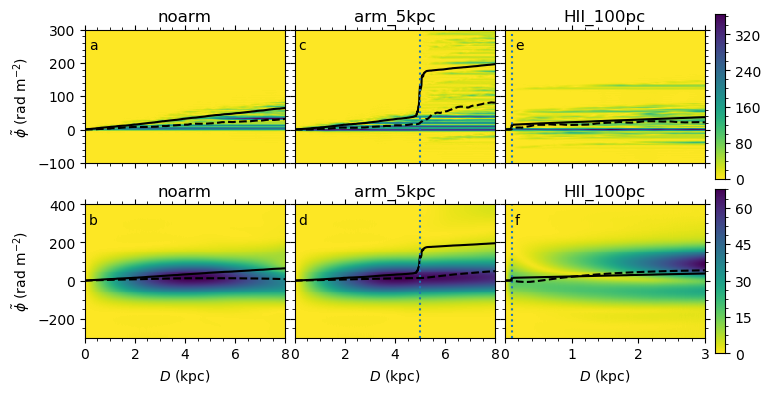

In [291]:
#fig, axes = plt.subplots(nrows=len(models), ncols=2, sharey='row', sharex=True)

cm = 'viridis_r'

abc = string.ascii_lowercase[:6]

fig = plt.figure(figsize=(8,4.5))
grid = ImageGrid(fig, 111, nrows_ncols=(2,3), aspect=False, direction='column',
                cbar_location='right', axes_pad=0.1, cbar_mode='edge',
                share_all=False)

for i, m in enumerate(models):
    zkpc = m['input']['z'].to(u.kpc)
    #fig, ax = plt.subplots(figsize=(4,3))
    ax = grid[2*i]
    im = ax.imshow(m['cube_parkes'][:,::-1].transpose(), extent=[zkpc[0].value,zkpc[-1].value,
                                                      m['phi_parkes'][0], m['phi_parkes'][-1]],
              aspect='auto', cmap=cm)#, vmin=0, vmax=200)
    ax.set_ylim(-100,300)
    
    ax.plot(zkpc, m['phi'].mean(axis=0), 'k-')
    ax.set_title(m['input']['name'])# + ' $300-480$ MHz')
    if m['input']['narm'] > 0:
        ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted')
    grid.cbar_axes[2*i].colorbar(im)

    phi = m['phi_parkes']
    dphi = phi[1]-phi[0]
    T = np.abs(m['cube_parkes'])
    mom1 = np.sum(T * phi[np.newaxis,:], axis=1) / np.sum(T, axis=1)
    ax.plot(zkpc, mom1, 'k--')
    
    ylim = ax.get_ylim()
    yy = 0.85*(ylim[1]-ylim[0]) + ylim[0]
    ax.text(0.15, yy, abc[2*i])

    ax = grid[2*i+1]
    im = ax.imshow(m['cube_drao'][:,::-1].transpose(), extent=[zkpc[0].value,zkpc[-1].value,
                                                    m['phi_drao'][0], m['phi_drao'][-1]],
              aspect='auto', cmap=cm)#, vmin=0, vmax=50)
    grid.cbar_axes[2*i+1].colorbar(im)
    
    ax.set_ylim(-300,400)

    ax.plot(zkpc, m['phi'].mean(axis=0), 'k-')
    ax.set_title(m['input']['name'])# + ' $1300-1700$ MHz')
    if m['input']['narm'] > 0:
        ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted')

    phi = m['phi_drao']
    dphi = phi[1]-phi[0]
    T = np.abs(m['cube_drao'])
    mom1 = np.sum(T * phi[np.newaxis,:], axis=1) / np.sum(T, axis=1)
    ax.plot(zkpc, mom1, 'k--', label=m['input']['name'])
    
    ylim = ax.get_ylim()
    yy = 0.85*(ylim[1]-ylim[0]) + ylim[0]
    ax.text(0.15, yy, abc[2*i+1])

for g in grid:
    g.set_aspect( (2./3.)*(g.get_xlim()[1]-g.get_xlim()[0]) / (g.get_ylim()[1]-g.get_ylim()[0]))

grid[1].set_xlabel(r'$D$ (kpc)')
grid[3].set_xlabel(r'$D$ (kpc)')
grid[5].set_xlabel(r'$D$ (kpc)')

grid[0].set_ylabel(r'$\tilde{\phi}$ (rad m$^{-2}$)')
grid[1].set_ylabel(r'$\tilde{\phi}$ (rad m$^{-2}$)')

#cb = grid[1].get_colorbar()

fig.subplots_adjust(right=0.9, left=0.1)

#plt.tight_layout()
fig.savefig('../figures/RM_spectrum_image_grid.pdf')

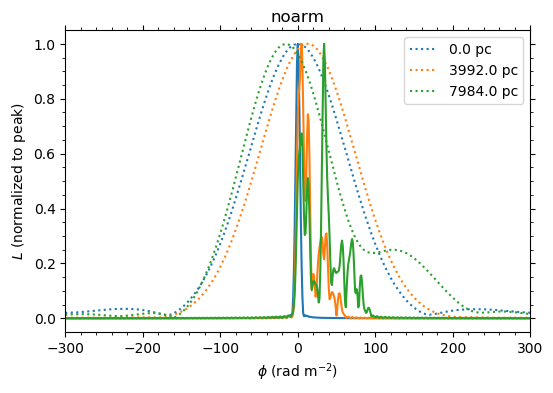

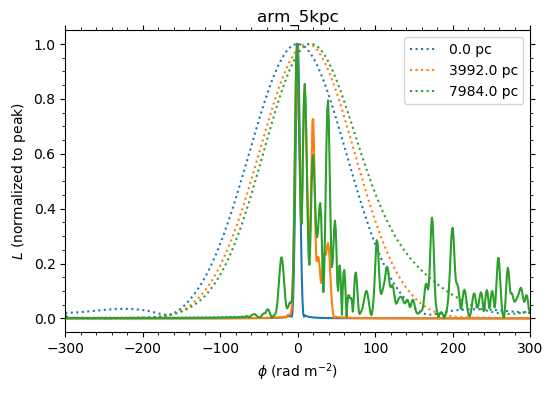

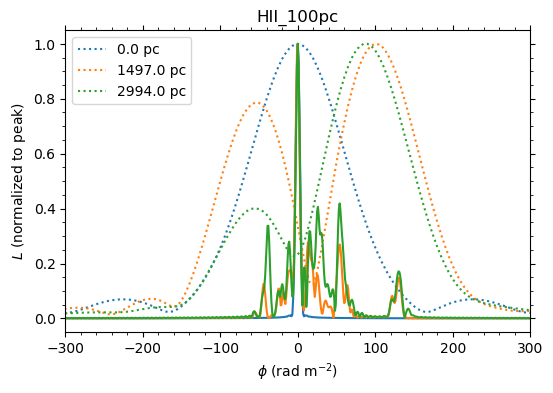

In [20]:
for m in models:
    fig, ax = plt.subplots()
    ax.set_prop_cycle(cycler('color', ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e',
                                            '#2ca02c', '#2ca02c', '#d62728', '#d62728', 
                                           '#9467bd', '#9467bd']) +
                           cycler('linestyle', ['-', ':','-', ':','-', ':','-', ':','-', ':']))
    for i in range(0,m['input']['nz'],m['input']['nz']/2-1):
        ax.plot(m['phi_drao'], np.abs(m['cube_drao'][i,:])/np.max(np.abs(m['cube_drao'][i,:])), ':',
                label='{:.1f}'.format(m['input']['z'][i]))
        ax.plot(m['phi_parkes'], np.abs(m['cube_parkes'][i,:])/np.max(np.abs(m['cube_parkes'][i,:])), '-')#,
#                label='{:.1f}'.format(m['input']['z'][i]))

    ax.legend(loc='best')
    ax.set_xlim(-300,300)
    ax.set_ylabel('$L$ (normalized to peak)')
    ax.set_xlabel(r'$\phi$ (rad m$^{-2}$)')
    ax.set_title(m['input']['name'])

In [21]:
def pBurnTribble(sigma, l):
    s = np.exp(-(2*sigma**2 * l**4).to(1, equivalencies=u.dimensionless_angles()))
    try:
        idx = np.where(s < 0.5)[0]
        ss = (-1 / (-sigma[idx] * l**2 * 2*np.sqrt(2))).to(1, equivalencies=u.dimensionless_angles())
        N = (0.5/ss[0])**2
        ss = (-np.sqrt(N) / (-sigma[idx] * l**2 * 2*np.sqrt(2))).to(1, equivalencies=u.dimensionless_angles())
        s[idx] = ss
        print 'N = ', N
    except:
        print 'Nothing with s < 0.5; using Burn only'
    return s

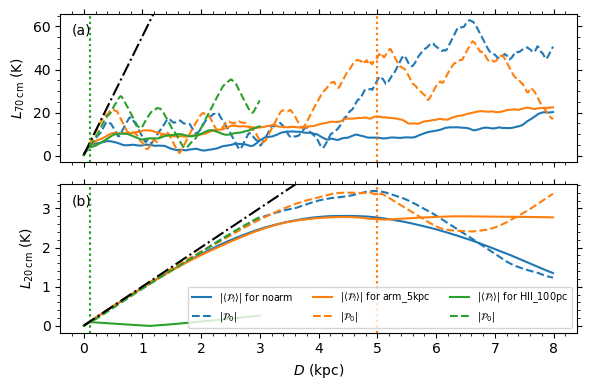

In [247]:
pnum=1
nplots = 2

fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=(6,4), sharex=True)
dz = m['input']['z'][1] - m['input']['z'][0]

for i, l in enumerate([0.7, 0.2]*u.m):
#for i, l in enumerate([0.0130,0.2, 0.7]*u.m):
    axes[i].set_prop_cycle(cycler('color', ['#1f77b4', '#1f77b4', #'#1f77b4',
                                            '#ff7f0e', '#ff7f0e', #'#ff7f0e',
                                            '#2ca02c', '#2ca02c']) + #, '#2ca02c', '#d62728', '#d62728', 
                                           #'#9467bd', '#9467bd']) +
                           cycler('linestyle', ['-', '--',#'-.',
                                                '-', '--',#'-.',
                                                '-', '--']))#,'-.','-', '--','-', '--']))


    for m in models:
        z = m['input']['z']
        dz = m['input']['dz']
        zkpc = z.to(u.kpc)
        xmax = 13*u.kpc
        idx20cm = np.argmin(np.abs(m['input']['wlen']-l).value)
        lref = 20*u.cm
        P = np.mean(m['P'][:,:,idx20cm], axis=0)
        p = axes[i].plot(zkpc, np.abs(P).to(u.K),
                     label=r'$| \langle \mathcal{P}_i \rangle |$ for ' + m['input']['name'])
                     #label=r'$n_\mathrm{{arm}} = {:.1f} \, \mathrm{{cm}}^{{-3}}$'.format(m['input']['narm'].value))
        #axes[i].set_title(r'$\lambda = {:.1f} \, \mathrm{{cm}}$ ({:.2f} GHz)'.format(m['input']['wlen'][idx20cm].to(u.cm).value,
        #                                                                            m['input']['wlen'][idx20cm].to(u.GHz, equivalencies=u.spectral()).value))
        axes[i].set_yscale('linear')
        axes[i].set_ylabel(r'$L_{{{:.0f} \, \mathrm{{cm}}}}$ (K)'.format(l.to(u.cm).value))
        
        if m['input']['narm'] > 0*u.cm**-3:
            for ax in axes:
                ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())
        
        #axes[i].plot(zkpc, np.mean(np.abs(m['P'][:,:,idx20cm]), axis=0), label='one sightline')
        axes[i].plot(zkpc, np.abs(m['P'][10,:,idx20cm]), label='$|\mathcal{P}_0|$')
        
        Rl2 = (np.mean(m['phi'], axis=0) * l**2).to(u.radian)
        Lemis = np.cumsum(m['input']['emis']*dz*(l/lref)**m['input']['beta']).to(u.K)
#        axes[i].plot(zkpc, np.abs(np.sin(Rl2) / Rl2) * pBurnTribble(np.std(m['phi'], axis=0), l) * Lemis, label='$|\sin (R \lambda^2) / R \lambda^2|$')
        #axes[i].plot(zkpc, np.abs(np.sin(Rl2) / Rl2) * Lemis, label='$|\sin (R \lambda^2) / R \lambda^2|$')
    
    axes[i].text(-0.2, axes[i].get_ylim()[1]*0.85, '({})'.format(abc[i]))

        
    ylim = axes[i].get_ylim()
    m = models[0]
    axes[i].plot(m['input']['z'].to(u.kpc).value,
                 np.cumsum(m['input']['emis']*m['input']['dz']*(l/lref)**m['input']['beta']).to(u.K), 'k-.')#,
#               label=r'$\int \varepsilon \, ds$')
    axes[i].set_ylim(ylim)

axes[-1].legend(loc='lower right', fontsize='x-small', ncol=3)
axes[-1].set_xlabel(r'$D$ (kpc)')

plt.tight_layout()
fig.savefig('../figures/combined_L_s.pdf')

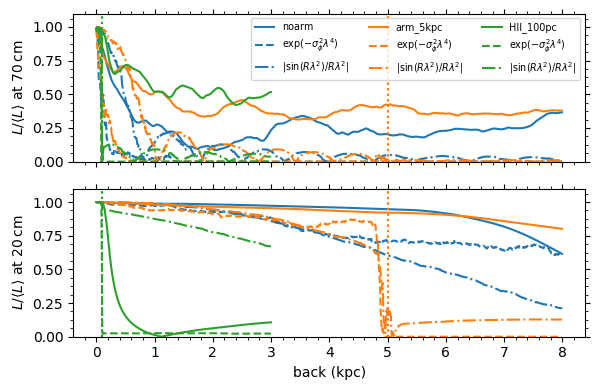

In [23]:
pnum=1
nplots = 2

fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=(6,4), sharex=True)
dz = m['input']['z'][1] - m['input']['z'][0]

for i, l in enumerate([0.7, 0.2]*u.m):
    axes[i].set_prop_cycle(cycler('color', ['#1f77b4', '#1f77b4', '#1f77b4',
                                            '#ff7f0e', '#ff7f0e', '#ff7f0e',
                                            '#2ca02c', '#2ca02c', '#2ca02c']) + #, '#d62728', '#d62728', 
                                           #'#9467bd', '#9467bd']) +
                           cycler('linestyle', ['-', '--','-.',
                                                '-', '--','-.',
                                                '-', '--','-.']))#,'-', '--','-', '--']))

    for m in models:
        z = m['input']['z']
        zkpc = z.to(u.kpc)
        xmax = 13*u.kpc
        idx20cm = np.argmin(np.abs(m['input']['wlen']-l).value)
        lref = 20*u.cm
        P = np.mean(m['P'][:,:,idx20cm], axis=0)
        p = axes[i].plot(zkpc, np.abs(P).to(u.K) / np.mean(np.abs(m['P'][:,:,idx20cm]), axis=0),
                     label=m['input']['name'])
        axes[i].set_yscale('linear')
        axes[i].set_ylabel(r'$L / \langle L \rangle$ at ${:.0f} \, \mathrm{{cm}}$'.format(l.to(u.cm).value))
        
        if m['input']['narm'] > 0*u.cm**-3:
            for ax in axes:
                ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())
        
        axes[i].plot(zkpc, np.exp(-2*(np.std(m['phi'], axis=0)**2 * l**4).value),
                label=r'$\exp(-\sigma_\phi^2 \lambda^4)$')
        Rl2 = (np.mean(m['phi'], axis=0) * l**2).to(u.radian)
        axes[i].plot(zkpc, np.abs(np.sin(Rl2) / Rl2), label='$|\sin (R \lambda^2) / R \lambda^2|$')
        
    axes[i].set_ylim(0,1.1)

axes[0].legend(loc='best', fontsize='x-small', ncol=3)
axes[-1].set_xlabel(r'back (kpc)')

plt.tight_layout()

N =  0.747859626743
N =  0.747859626743
Nothing with s < 0.5; using Burn only
Nothing with s < 0.5; using Burn only


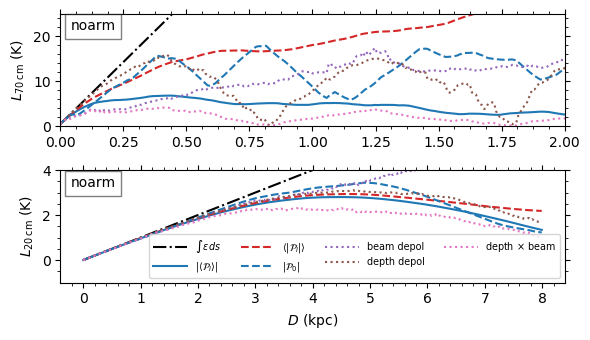

In [190]:
larr = [0.7*u.m, 0.2*u.m]
fig, axes = plt.subplots(nrows=len(larr), figsize=(6,3.5), sharex=False)

colorstr = ['#1f77b4', #'#ff7f0e', '#2ca02c',
            '#d62728','#9467bd']

cycle = cycler('color', [x for x in colorstr for _ in range(4)])
for ax, l in zip(axes, larr):
    ax.set_prop_cycle(plt.rcParams['axes.prop_cycle'][3:])

    for m in [models[0]]:
        z = m['input']['z']
        dz = m['input']['dz']
        zkpc = z.to(u.kpc)
        xmax = 13*u.kpc
        idx20cm = np.argmin(np.abs(m['input']['wlen']-l).value)
        lref = 20*u.cm

        ax.plot(m['input']['z'].to(u.kpc).value,
                 np.cumsum(m['input']['emis']*m['input']['dz']*(l/lref)**m['input']['beta']).to(u.K), 'k-.',
               label=r'$\int \varepsilon \, ds$')

        P = np.mean(m['P'][:,:,idx20cm], axis=0)
        p = ax.plot(zkpc, np.abs(P).to(u.K),
                     label=r'$| \langle \mathcal{P}_i \rangle |$', color='#1f77b4')
        ax.set_yscale('linear')
        ax.set_ylabel(r'$L_{{{:.0f} \, \mathrm{{cm}}}}$ (K)'.format(l.to(u.cm).value))

        if m['input']['narm'] > 0*u.cm**-3:
            for ax in axes:
                ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())

        ax.plot(zkpc, np.mean(np.abs(m['P'][:,:,idx20cm]), axis=0), '--',
                label=r'$\langle | \mathcal{P}_i | \rangle$')
        ax.plot(zkpc, np.abs(m['P'][10,:,idx20cm]).value, '--', color='#1f77b4',
                label=r'$| \mathcal{P}_0 |$')

        Rl2 = (np.mean(m['phi'], axis=0) * l**2).to(u.radian)
        Lemis = np.cumsum(m['input']['emis']*dz*(l/lref)**m['input']['beta']).to(u.K)
        ax.plot(zkpc, pBurnTribble(np.std(m['phi'], axis=0), l) * Lemis, ':',
                label='beam depol')
        ax.plot(zkpc, np.abs(np.sin(Rl2) / Rl2) * Lemis, ':',
                label='depth depol')
        ax.plot(zkpc, np.abs(np.sin(Rl2) / Rl2) * pBurnTribble(np.std(m['phi'], axis=0), l) * Lemis, ':',
                label=r'depth $\times$ beam')

        ax.set_ylim(0, 1.2*np.max(np.mean(np.abs(m['P'][:,:,idx20cm]), axis=0)).value)
        
    m = models[0]
    #ax.set_title(m['input']['name'])
    ax.text(0.02,0.85,m['input']['name'], horizontalalignment='left',
                transform=ax.transAxes, bbox=dict(facecolor='white',alpha=0.5))

axes[1].set_ylim(-1,4)
axes[0].set_xlim(0,2)
axes[0].set_ylim(0,25)
    
axes[1].legend(loc='best', fontsize='x-small', ncol=4, handlelength=3.5)
ax.set_xlabel(r'$D$ (kpc)')

plt.tight_layout()
fig.savefig('../figures/depol_mechanisms.pdf')

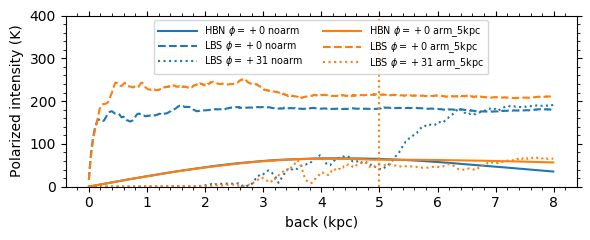

In [266]:
colorstr = ['#1f77b4', '#ff7f0e', '#2ca02c',
            '#d62728','#9467bd']

cycle = cycler('color', [x for x in colorstr for _ in range(3)]) + \
                  cycler('linestyle', ['-', '--', ':']#, '-.']
                         *5)

fig, ax = plt.subplots(figsize=(6,2.5))

ax.set_prop_cycle(cycle)
for m in models[:2]:
    zkpc = m['input']['z'].to(u.kpc).value
    idx0RM_drao = np.argmin(np.abs(m['phi_drao'] - (0)))
    p=ax.plot(zkpc, np.abs(m['cube_drao'][:,idx0RM_drao]),
            label=r'HBN $\phi={:+.0f}$ '.format(m['phi_drao'][idx0RM_drao]) + m['input']['name'])

    #idx0RM_drao = np.argmin(np.abs(m['phi_drao'] - (15)))
    #ax.plot(zkpc, np.abs(m['cube_drao'][:,idx0RM_drao]), ':',
    #        label=r'DRAO $\phi={:+.0f}$ '.format(m['phi_drao'][idx0RM_drao]) + m['input']['name'])

    idx0RM_parkes = np.argmin(np.abs(m['phi_parkes'] - 0))
    ax.plot(zkpc, np.abs(m['cube_parkes'][:,idx0RM_parkes]),
            label=r'LBS $\phi={:+.0f}$ '.format(m['phi_parkes'][idx0RM_parkes]) + m['input']['name'])

    idx0RM_parkes = np.argmin(np.abs(m['phi_parkes'] - 31))
    ax.plot(zkpc, np.abs(m['cube_parkes'][:,idx0RM_parkes]),
            label=r'LBS $\phi={:+.0f}$ '.format(m['phi_parkes'][idx0RM_parkes]) + m['input']['name'])
    
    if m['input']['narm'] > 0*u.cm**-3:
        ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())
    
ax.legend(loc='upper center', ncol=2, fontsize='x-small', labelspacing=0.1, handlelength=4)
ax.set_ylim(0,400)
ax.set_xlabel(r'back (kpc)')
ax.set_ylabel(r'Polarized intensity (K)')
plt.tight_layout()
fig.savefig('../figures/PI_phi_s.pdf')

In [281]:
help(ax.legend)

Help on method legend in module matplotlib.axes._axes:

legend(self, *args, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Places a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line.set_label('Label via method')
        line, = ax.plot([1, 2, 3])
        ax.legend()
    
    Specific lines can be excluded from

In [284]:
p0

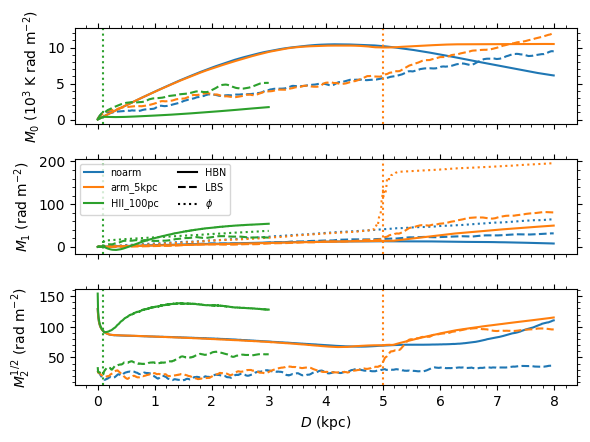

In [298]:
fig, axes = plt.subplots(3, figsize=(6,4.5), sharex=True)

colorstr = ['#1f77b4', '#ff7f0e', '#2ca02c',
            '#d62728','#9467bd']

cycle = cycler('color', [x for x in colorstr for _ in range(2)]) + \
                  cycler('linestyle', ['-', '--']#, ':'], '-.']
                         *5)

for ax in axes:
    ax.set_prop_cycle(cycle)

handles = []
for m in models:
    zkpc = m['input']['z'].to(u.kpc).value

    phi = m['phi_drao']
    dphi = phi[1]-phi[0]
    T = np.abs(m['cube_drao'])
    mom0 = np.sum(T, axis=1) * dphi
    mom1 = np.sum(T * phi[np.newaxis,:], axis=1) / np.sum(T, axis=1)
    mom2 = np.sum(T * (phi[np.newaxis,:] - mom1[:,np.newaxis])**2, axis=1) / np.sum(T, axis=1)
    p0=axes[0].plot(zkpc, mom0/1e3, label=m['input']['name'])
    p1=axes[1].plot(zkpc, mom1, label=m['input']['name'])
    p2=axes[2].plot(zkpc, mom2**0.5, label=m['input']['name'])
    
    handles.append(p1[0])
    
    axes[1].plot(zkpc, np.mean(m['phi'], axis=0), ':', color=p1[0].get_color())

    phi = m['phi_parkes']
    dphi = phi[1]-phi[0]
    T = np.abs(m['cube_parkes'])
    mom0 = np.sum(T, axis=1) * dphi
    mom1 = np.sum(T * phi[np.newaxis,:], axis=1) / np.sum(T, axis=1)
    mom2 = np.sum(T * (phi[np.newaxis,:] - mom1[:,np.newaxis])**2, axis=1) / np.sum(T, axis=1)
    p0=axes[0].plot(zkpc, mom0/1e3)
    p1=axes[1].plot(zkpc, mom1)
    p2=axes[2].plot(zkpc, mom2**0.5)

    if m['input']['narm'] > 0*u.cm**-3:
        for ax in axes:
            ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p0[0].get_color())

handles.append(mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=15, label='HBN'))
handles.append(mlines.Line2D([], [], color='black', linestyle='--',
                          markersize=15, label='LBS'))
handles.append(mlines.Line2D([], [], color='black', linestyle=':',
                              markersize=15, label=r'$\phi$'))

leg = axes[1].legend(handles=handles, loc='upper left', ncol=2, fontsize='x-small')
#ax.set_ylim(0,300)
axes[-1].set_xlabel(r'$D$ (kpc)')
axes[0].set_ylabel(r'$M_0$ ($10^3$ K rad m$^{-2}$)')
#axes[0].set_ylabel(r'$\int L \, d\phi$ (K rad m$^{-2}$)')
axes[1].set_ylabel(r'$M_1$ (rad m$^{-2}$)')
#axes[1].set_ylabel(r'$\int L \, \phi \, d\phi / \int L \, d\phi$ (rad m$^{-2}$)')
axes[2].set_ylabel(r'$M_2^{1/2}$ (rad m$^{-2})$')
#axes[2].set_ylabel(r'$\int L (\phi - \mathrm{mom1}) d\phi / \int L \, d\phi$ (rad m$^{-2}$)')

fig.tight_layout()
fig.savefig('../figures/moments.pdf')

In [296]:
m['input']['z']

<Quantity [   0.,    3.,    6.,    9.,   12.,   15.,   18.,   21.,   24.,
             27.,   30.,   33.,   36.,   39.,   42.,   45.,   48.,   51.,
             54.,   57.,   60.,   63.,   66.,   69.,   72.,   75.,   78.,
             81.,   84.,   87.,   90.,   93.,   96.,   99.,  102.,  105.,
            108.,  111.,  114.,  117.,  120.,  123.,  126.,  129.,  132.,
            135.,  138.,  141.,  144.,  147.,  150.,  153.,  156.,  159.,
            162.,  165.,  168.,  171.,  174.,  177.,  180.,  183.,  186.,
            189.,  192.,  195.,  198.,  201.,  204.,  207.,  210.,  213.,
            216.,  219.,  222.,  225.,  228.,  231.,  234.,  237.,  240.,
            243.,  246.,  249.,  252.,  255.,  258.,  261.,  264.,  267.,
            270.,  273.,  276.,  279.,  282.,  285.,  288.,  291.,  294.,
            297.,  300.,  303.,  306.,  309.,  312.,  315.,  318.,  321.,
            324.,  327.,  330.,  333.,  336.,  339.,  342.,  345.,  348.,
            351.,  354.,  357.,  360.,

In [299]:
for s in [0, 100, 200, 300, 400, 1000, 2000, 3000]*u.pc:
    print s, mom1[np.argmin(np.abs(s - m['input']['z']))]

0.0 pc 0.013476120606922146
100.0 pc 0.40383588972560835
200.0 pc 5.871348378841863
300.0 pc 7.783435084788446
400.0 pc 11.106427719812903
1000.0 pc 13.549951841628873
2000.0 pc 22.512329646088745
3000.0 pc 21.415311117527512


In [294]:
mom1[np.argmin(np.abs(200*u.pc - m['input']['z']))], mom1[np.argmin(np.abs(3000*u.pc - m['input']['z']))]

(-5.307082538791545, 53.931284382932944)

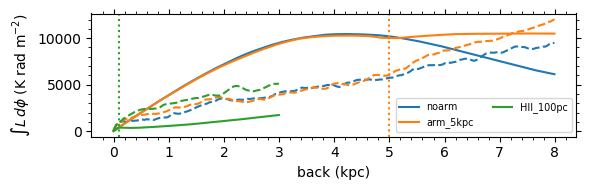

In [43]:
fig, ax = plt.subplots(figsize=(6,2))

cycle = cycler('color', [x for x in colorstr for _ in range(2)]) + \
                  cycler('linestyle', ['-', '--']#, ':']#, '-.']
                         *5)

ax.set_prop_cycle(cycle)

for m in models:
    zkpc = m['input']['z'].to(u.kpc).value
    p=ax.plot(zkpc, np.sum(m['cube_drao'], axis=1)*(m['phi_drao'][1]-m['phi_drao'][0]),
            label=m['input']['name'])

    ax.plot(zkpc, np.sum(m['cube_parkes'], axis=1)*(m['phi_parkes'][1]-m['phi_parkes'][0]))#,
#            label=r'Parkes ' + m['input']['name'])
    if m['input']['narm'] > 0*u.cm**-3:
        ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())

ax.legend(loc='best', ncol=2, fontsize='x-small')
#ax.set_ylim(0,300)
ax.set_xlabel(r'back (kpc)')
ax.set_ylabel(r'$\int L \, d\phi$ (K rad m$^{-2}$)')
plt.tight_layout()
fig.savefig('../figures/L_integrated.pdf')

In [44]:
nu = m['input']['wlen'].to(u.Hz, equivalencies=u.spectral())
idxdrao = np.where(np.all([nu < 1.75*u.GHz, nu > 1.28*u.GHz], axis=0))[0]
idxparkes = np.where(np.all([nu < 480*u.MHz, nu > 300*u.MHz], axis=0))[0]

In [45]:
emis = m['input']['emis'][:,np.newaxis]
dz = m['input']['dz']
wlenbeta = ((m['input']['wlen'][idxdrao]/lref).to(1)**m['input']['beta'])[np.newaxis,:]
dphi = (m['phi_drao'][1] - m['phi_drao'][0])*u.rad*u.m**-2
intemis=np.sum(emis*dz*wlenbeta*dphi, axis=1)

In [46]:
np.cumsum(intemis)

<Quantity [   14.37487675,    28.7497535 ,    43.12463025,    57.499507  ,
              71.87438375,    86.2492605 ,   100.62413725,   114.999014  ,
             129.37389074,   143.74876749,   158.12364424,   172.49852099,
             186.87339774,   201.24827449,   215.62315124,   229.99802799,
             244.37290474,   258.74778149,   273.12265824,   287.49753499,
             301.87241174,   316.24728849,   330.62216524,   344.99704199,
             359.37191873,   373.74679548,   388.12167223,   402.49654898,
             416.87142573,   431.24630248,   445.62117923,   459.99605598,
             474.37093273,   488.74580948,   503.12068623,   517.49556298,
             531.87043973,   546.24531648,   560.62019323,   574.99506998,
             589.36994672,   603.74482347,   618.11970022,   632.49457697,
             646.86945372,   661.24433047,   675.61920722,   689.99408397,
             704.36896072,   718.74383747,   733.11871422,   747.49359097,
             761.86846772

-1


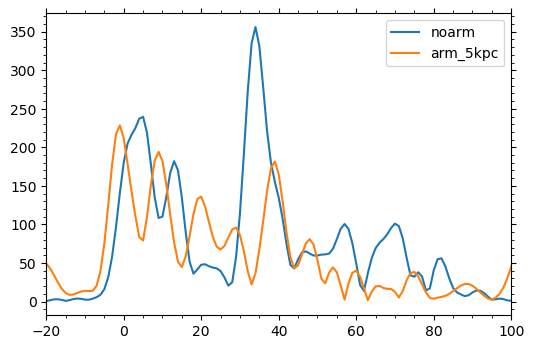

In [47]:
m = models[0]
plt.plot(m['phi_parkes'], np.abs(m['cube_parkes'][-1,:]), label=m['input']['name'])
m = models[1]
plt.plot(m['phi_parkes'], np.abs(m['cube_parkes'][-1,:]), label=m['input']['name'])

plt.legend()
plt.xlim(-20,100)
print m['phi_parkes'][np.argmax(m['cube_parkes'][-1,:])]

123 15


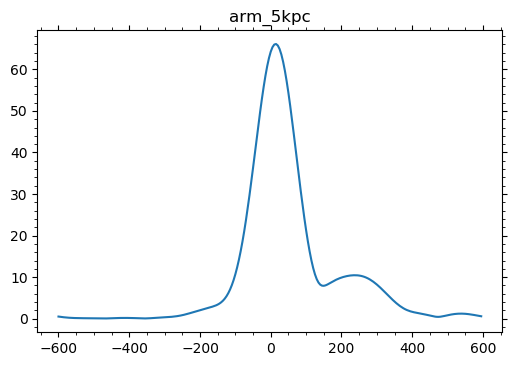

In [641]:
m = models[1]
plt.plot(m['phi_drao'], np.abs(m['cube_drao'][-1,:]))
plt.title(m['input']['name'])
#plt.xlim(-20,100)
idx= np.argmax(m['cube_drao'][-1,:])
print idx, m['phi_drao'][idx]

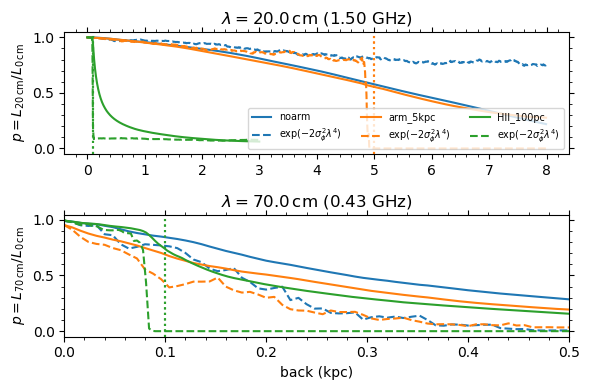

In [260]:
pnum=1
nplots = 2

fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=(6,4), sharex=False)

for i, l in enumerate([0.2, 0.7]*u.m):
    Pexp = np.cumsum(m['input']['emis']*m['input']['dz']*(l/lref)**m['input']['beta']).to(u.K)
    axes[i].set_prop_cycle(cycler('color', ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e',
                                            '#2ca02c', '#2ca02c', '#d62728', '#d62728', 
                                           '#9467bd', '#9467bd']) +
                           cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--','-', '--']))
    
    for m in models:
        z = m['input']['z']
        zkpc = z.to(u.kpc)
        idx20cm = np.argmin(np.abs(m['input']['wlen']-l).value)
        lref = 20*u.cm
        P = np.mean(m['P'][:,:,idx20cm], axis=0)
        Pexp = np.cumsum(m['input']['emis']*m['input']['dz']*(l/lref)**m['input']['beta']).to(u.K)

        p = axes[i].plot(zkpc, np.abs(P).to(u.K) / Pexp,
                     label=m['input']['name'])
                     #label=r'$n_\mathrm{{arm}} = {:.1f} \, \mathrm{{cm}}^{{-3}}$'.format(m['input']['narm'].value))
        axes[i].plot(zkpc, np.exp(-2*(np.std(m['phi'], axis=0)**2 * l**4).value),
                    label=r'$\exp(-2\sigma_\phi^2 \lambda^4)$')
        axes[i].set_title(r'$\lambda = {:.1f} \, \mathrm{{cm}}$ ({:.2f} GHz)'.format(m['input']['wlen'][idx20cm].to(u.cm).value,
                                                                                    m['input']['wlen'][idx20cm].to(u.GHz, equivalencies=u.spectral()).value))
        #axes[i].set_yscale('log')
        axes[i].set_ylabel(r'$p = L_{{{:.0f} \, \mathrm{{cm}}}} / L_{{0  \, \mathrm{{cm}}}}$'.format(l.to(u.cm).value))
        #axes[i].set_ylim(1e-3,2)

        if m['input']['narm'] > 0*u.cm**-3:
            for ax in axes:
                ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())
axes[0].legend(loc='lower right', fontsize='x-small', ncol=len(models))
axes[-1].set_xlim(0,0.5)


axes[-1].set_xlabel(r'back (kpc)')
plt.tight_layout()
fig.savefig('../figures/depol_factor.pdf')

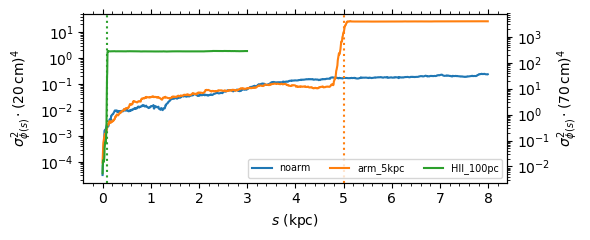

In [121]:
fig, ax = plt.subplots(figsize=(6,2.5))

#ax.set_prop_cycle(cycler('color', ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e',
#                                            '#2ca02c', '#2ca02c', '#d62728', '#d62728', 
#                                           '#9467bd', '#9467bd']) +
#                           cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--','-', '--']))
l = 0.2*u.m
for m in models:
    z = m['input']['z']
    zkpc = z.to(u.kpc)

    p = ax.plot(zkpc, np.std(m['phi'], axis=0)**2 * l**4,
            label=m['input']['name'])
#            label=r'$n_\mathrm{{arm}} = {:.1f} \, \mathrm{{cm}}^{{-3}}$'.format(m['input']['narm'].value))
    if m['input']['narm'] > 0*u.cm**-3:
        ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())
    

ax.set_yscale('log')

axright = ax.twinx()
axright.set_ylim((ax.get_ylim()*(0.7*u.m / l)**4).to(u.dimensionless_unscaled).value)
axright.set_ylabel(r'$\sigma_{\phi(s)}^2 \cdot (70 \, \mathrm{cm})^4$')

axright.set_yscale('log')

ax.set_ylabel(r'$\sigma_{\phi(s)}^2 \cdot (20 \, \mathrm{cm})^4$')

ax.legend(loc='lower right', fontsize='x-small', ncol=3)
ax.set_xlabel(r'$s$ (kpc)')
plt.tight_layout()
fig.savefig('../figures/sigma_lambda4.pdf')

Text(0,0.5,'$\\phi (70 \\, \\mathrm{cm})^2 / \\sigma^2_\\phi (70 \\, \\mathrm{cm})^4$')

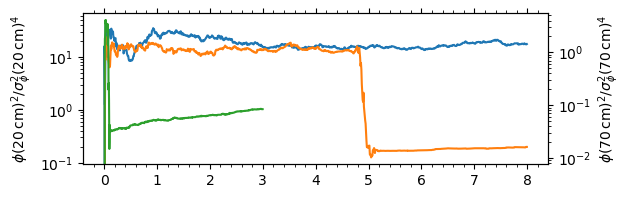

In [193]:
fig, ax = plt.subplots(figsize=(6,2))

#ax.set_prop_cycle(cycler('color', ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e',
#                                            '#2ca02c', '#2ca02c', '#d62728', '#d62728', 
#                                           '#9467bd', '#9467bd']) +
#                           cycler('linestyle', ['-', '--','-', '--','-', '--','-', '--','-', '--']))

l=0.2*u.m
for m in models:
    zkpc = m['input']['z'].to(u.kpc)
    phil2 = np.median(m['phi'], axis=0) * l**2
    sl4 = np.std(m['phi'], axis=0)**2 * l**4
    ax.plot(zkpc, phil2/sl4)

ax.set_ylabel(r'$\phi ({:.0f} \, \mathrm{{cm}})^2 / \sigma^2_\phi ({:.0f} \, \mathrm{{cm}})^4$'.format(
        l.to(u.cm).value, l.to(u.cm).value))

ax.set_yscale('log')
axright = ax.twinx()
axright.set_yscale('log')
axright.set_ylim((ax.get_ylim()[0] * (0.2/0.7)**2,
                ax.get_ylim()[1] * (0.2/0.7)**2))
axright.set_ylabel(r'$\phi ({:.0f} \, \mathrm{{cm}})^2 / \sigma^2_\phi ({:.0f} \, \mathrm{{cm}})^4$'.format(
        70, 70))



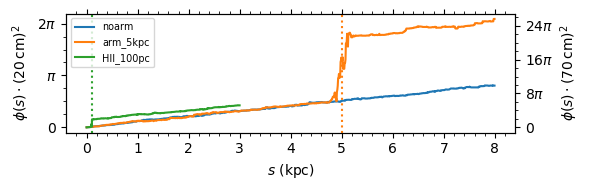

In [79]:
fig, ax = plt.subplots(figsize=(6,2))

l = 0.2*u.m
for m in models:
    z = m['input']['z']
    zkpc = z.to(u.kpc)

    p = ax.plot(zkpc, np.median(m['phi'], axis=0) * l**2,
            label=m['input']['name'])
#            label=r'$n_\mathrm{{arm}} = {:.1f} \, \mathrm{{cm}}^{{-3}}$'.format(m['input']['narm'].value))
    if m['input']['narm'] > 0*u.cm**-3:
        ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())

ax.yaxis.set_major_locator(MultipleLocator(np.pi))
ax.yaxis.set_minor_locator(MultipleLocator(np.pi/4))
ax.yaxis.set_major_formatter(FuncFormatter(piformat))

axright = ax.twinx()
axright.set_ylim((ax.get_ylim()*(70*u.cm / l)**2).to(u.radian, equivalencies=u.dimensionless_angles()).value)
axright.yaxis.set_major_locator(MultipleLocator(8*np.pi))
axright.yaxis.set_minor_locator(MultipleLocator(2*np.pi))
axright.yaxis.set_major_formatter(FuncFormatter(piformat))
axright.set_ylabel(r'$\phi(s) \cdot (70 \, \mathrm{cm})^2$')

ax.set_ylabel(r'$\phi(s) \cdot (20 \, \mathrm{cm})^2$')

ax.legend(loc='upper left', fontsize='x-small', ncol=1)
ax.set_xlabel(r'$s$ (kpc)')
plt.tight_layout()
fig.savefig('../figures/phi_lambda2.pdf')

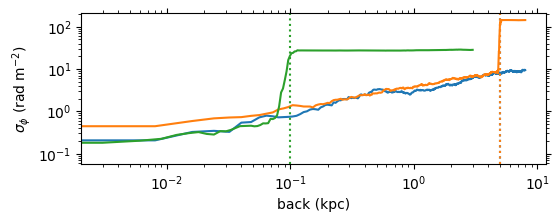

In [80]:
fig, ax = plt.subplots(figsize=(6,2))
for m in models:
    p = ax.plot(m['input']['z'].to(u.kpc), np.std(m['phi'], axis=0))
    ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted', color=p[0].get_color())
ax.set_ylabel(r'$\sigma_\phi$ (rad m$^{-2}$)')
ax.set_xlabel('back (kpc)')
ax.set_yscale('log')
ax.set_xscale('log')
fig.savefig('../figures/sigRM.pdf')

In [596]:
10*u.rad*u.m**-2 * ([1280,1750]*u.MHz).to(u.m, equivalencies=u.spectral())**2

<Quantity [0.54855663, 0.29347108] rad>

In [595]:
10*u.rad*u.m**-2 * ([300,480]*u.MHz).to(u.m, equivalencies=u.spectral())**2

<Quantity [9.98616865, 3.90084713] rad>

L_psi_phi_z_narm0_00_0cm_widarm100
L_psi_phi_z_narm1_00_0cm_widarm100
L_psi_phi_z_narm0_00_1cm_widarm100
L_psi_phi_z_narm1_00_1cm_widarm100


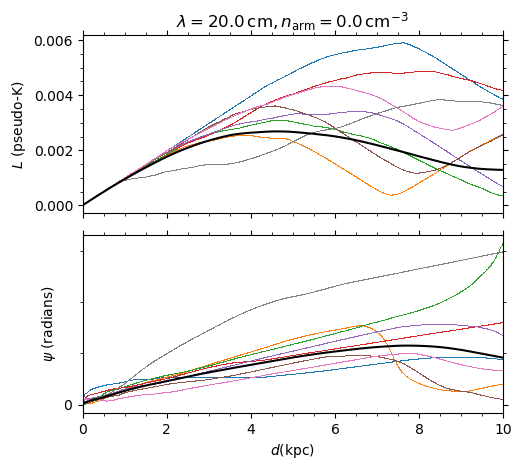

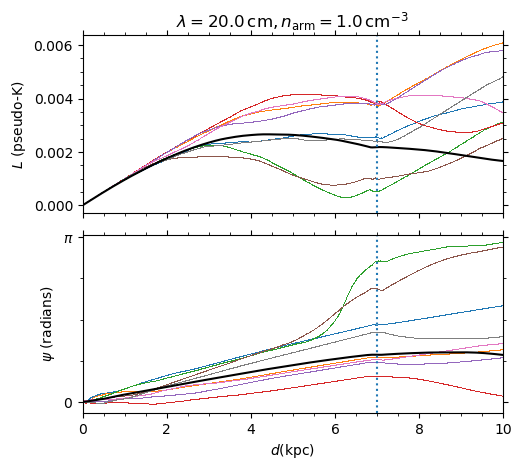

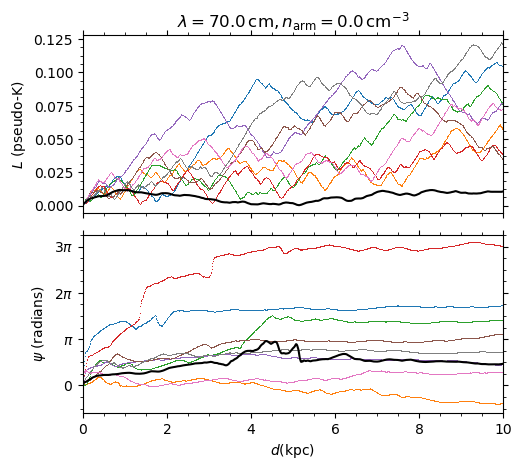

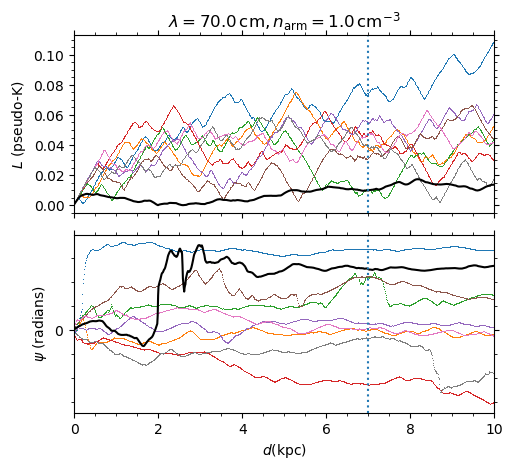

In [94]:
for l in [0.2, 0.7]*u.m:
    for m in models:
        pnum=1
        nplots = 2
        z = m['input']['z']
        zkpc = z.to(u.kpc)
        fig, axes = plt.subplots(nrows=nplots, ncols=1, figsize=(6,5), sharex=True)
        xmax = 13*u.kpc
        idx20cm = np.argmin(np.abs(m['input']['wlen']-l).value)
        for i in range(8):
            axes[0].plot(zkpc, np.abs(m['P'][i,:,idx20cm]), ',')
        P = np.mean(m['P'][:,:,idx20cm], axis=0)
        axes[0].plot(zkpc, np.abs(P), 'k-', label='$L(20 \, \mathrm{cm})$ for beam')

        axes[0].set_title(r'$\lambda = {:.1f} \, \mathrm{{cm}}, n_\mathrm{{arm}} = {:.1f} \, \mathrm{{cm}}^{{-3}}$'.format(m['input']['wlen'][idx20cm].to(u.cm).value,
                                                                                                                          m['input']['narm'].value))

        axes[0].set_yscale('linear')
        axes[0].set_ylabel(r'$L$ (pseudo-K)')
    #    axes[0].set_ylim(0.02,1)

        plt.setp(axes[0].get_xticklabels(), visible=False)

    #    axes[0].text(0.3, 0.8, r'model ' + model['inputs']['name'], transform=axes[0].transAxes)
        psi = 0.5*np.arctan2(m['P'].imag, m['P'].real)
        for i in range(8):
            axes[1].plot(zkpc, np.unwrap(psi[i,:,idx20cm]*2)/2, ',')
    #    axes[1].plot(zkpc, model['los'][0]['psiuw'][:,4], 'r--', markersize=1)

        psiP = 0.5*np.arctan2(P.imag, P.real)
        axes[1].plot(zkpc, np.unwrap(psiP*2)/2, 'k-', label='$\psi(20 \, \mathrm{cm})$ for beam')

    #    axes[1].set_ylim(-10,10)
        axes[1].set_ylabel(r'$\psi$ (radians)')
    #    plt.setp(axes[1].get_xticklabels(), visible=False)
        axes[1].yaxis.set_major_locator(MultipleLocator(np.pi))
        axes[1].yaxis.set_minor_locator(MultipleLocator(np.pi/4))
        axes[1].yaxis.set_major_formatter(FuncFormatter(piformat))
        #axes[1].set_ylim(-3*np.pi, np.pi)

    #    axes[2].plot(zkpc, np.mean(m['phi'], axis=0), 'k-', label=r'True $\phi$')
    #    axes[2].plot(zkpc, m['phimax_drao'], 'c-', label=r'$\phi_\mathrm{1500}$')
    #    axes[2].plot(zkpc, m['phimax_parkes'], 'm:', label=r'$\phi_\mathrm{300}$')
    #    axes[2].set_ylabel(r'$\phi \, \mathrm{ (rad} \, \mathrm{m)^{-2}}$')
        axes[1].set_xlabel(r'$d (\mathrm{kpc})$')
    #    axes[2].legend(loc='upper left', fontsize='small', labelspacing=0.1)#,ncol=2)

    #    plt.setp(axes[2].get_xticklabels(), visible=False)
        #axes[2].set_ylim(-100,100)
        axes[0].set_xlim(zkpc[0].value, zkpc[-1].value)


        if m['input']['narm'] > 0*u.cm**-3:
            for ax in axes:
                ax.axvline(x=m['input']['zarm'].to(u.kpc).value, linestyle='dotted')

    #    plt.setp(axes[2].get_xticklabels(), visible=False)



        #fig.draw()
    #    fig.tight_layout()
        fig.subplots_adjust(hspace=0.12, left=0.2)
        basefn = ('L_psi_phi_z_narm{:.2f}_{:.0f}cm_widarm{:.0f}'.format(m['input']['narm'].value,
                                                                        m['input']['wlen'][idx20cm].to(u.m).value,
                                                                  m['input']['widarm'].value)).replace('.','_')
        print basefn
        fig.savefig('../figures/' + basefn + '.pdf')

In [48]:
m = models[1]
wlen = m['input']['wlen']
nu = wlen.to(u.MHz, equivalencies=u.spectral())
Qnoise = np.random.normal(0,2.0, len(m['Pbeam'][-1,:]))*u.K
Unoise = np.random.normal(0,2.0, len(m['Pbeam'][-1,:]))*u.K
noisyP = m['Pbeam'][-1,:] + Qnoise + Unoise*1j

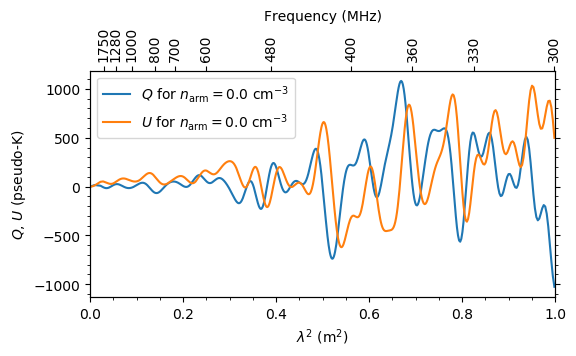

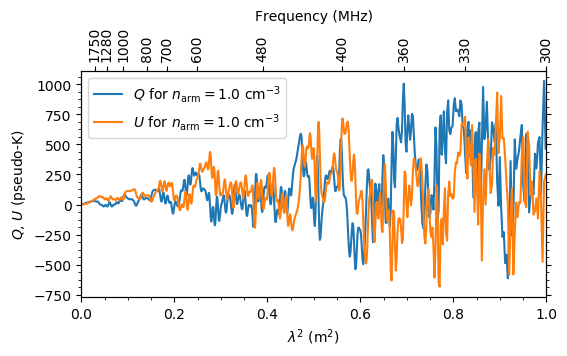

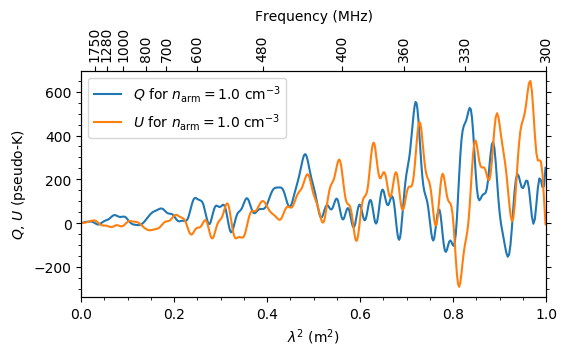

In [48]:
for m in models:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(m['input']['wlen']**2, m['Pbeam'][-1,:].real,
            label='$Q$ for $n_\mathrm{{arm}} = {:.1f}$ cm$^{{-3}}$'.format(m['input']['narm'].value))
    ax.plot(m['input']['wlen']**2, m['Pbeam'][-1,:].imag,
            label='$U$ for $n_\mathrm{{arm}} = {:.1f}$ cm$^{{-3}}$'.format(m['input']['narm'].value))
    ax.set_xlabel(r'$\lambda^2$ (m$^2$)')
    ax.set_ylabel(r'$Q$, $U$ (pseudo-K)')
    ax.set_xlim(0,1)
    #ax.set_ylim(-0.08,0.08)
    
    axtop = ax.twiny()
    axtop.set_xlim(ax.get_xlim())
    ticks = ([300,330,360,400,480,600,700,800,1000,1280,1750]*u.MHz).to(u.m, equivalencies=u.spectral())
    axtop.set_xticks((ticks**2).value)
    axtop.set_xticks((ticks**2).value, minor=True)
    labels=['{:.0f}'.format(x) for x in np.sqrt(axtop.get_xticks()*u.m**2).to(u.MHz, equivalencies=u.spectral()).value]
    axtop.set_xticklabels(labels)
    axtop.set_xlabel(r'Frequency (MHz)')
    for tick in axtop.get_xticklabels():
        tick.set_rotation(90)
    
    ax.legend(loc='best')
    basefn = ('spectrum_QU_narm{:.2f}'.format(m['input']['narm'].value)).replace('.','_')
    fig.savefig('../figures/' + basefn + '.pdf')

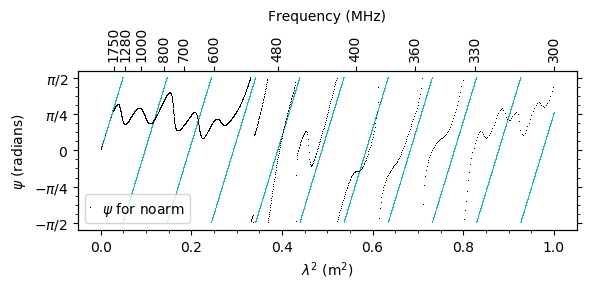

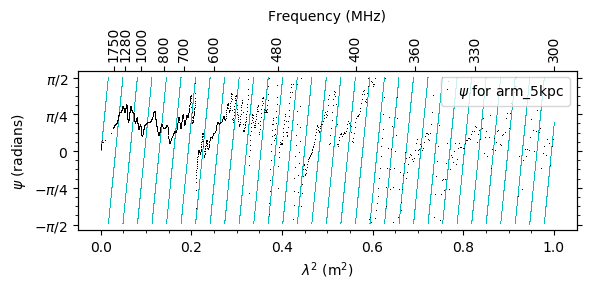

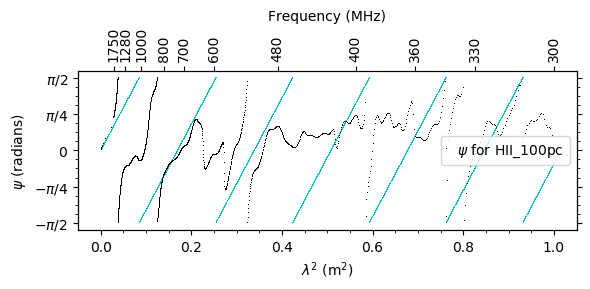

In [206]:
for m in models:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(m['input']['wlen']**2, m['psiPbeam'][-1,:].real, 'k,',
            label='$\psi$ for {}'.format(m['input']['name']))
    ax.set_xlabel(r'$\lambda^2$ (m$^2$)')
    ax.set_ylabel(r'$\psi$ (radians)')
    #ax.set_xlim(0,1)
    #ax.set_ylim(-0.08,0.08)
    
    axtop = ax.twiny()
    axtop.set_xlim(ax.get_xlim())
    ticks = ([300,330,360,400,480,600,700,800,1000,1280,1750]*u.MHz).to(u.m, equivalencies=u.spectral())
    axtop.set_xticks((ticks**2).value)
    axtop.set_xticks((ticks**2).value, minor=True)
    labels=['{:.0f}'.format(x) for x in np.sqrt(axtop.get_xticks()*u.m**2).to(u.MHz, equivalencies=u.spectral()).value]
    axtop.set_xticklabels(labels)
    axtop.set_xlabel(r'Frequency (MHz)')
    for tick in axtop.get_xticklabels():
        tick.set_rotation(90)
    ylim = ax.get_ylim()
    
    ll = np.arange(0,1,1./10000)*u.m**2
    rml2 = np.mean(m['phi'], axis=0)[-1]*ll / 2

    ax.plot(ll, np.arctan(np.tan(rml2)),'c,', zorder=-5)

    ax.set_ylim(ylim)
    
    ax.yaxis.set_major_locator(MultipleLocator(np.pi/4))
    ax.yaxis.set_major_formatter(FuncFormatter(piformat))
    
    ax.legend(loc='best', handlelength=0)
    basefn = ('spectrum_QU_{}'.format(m['input']['name'])).replace('.','_')
    fig.tight_layout()
    fig.savefig('../figures/' + basefn + '.pdf')

In [161]:
m['input']['wlen'][0]**2, (np.unwrap(m['psiPbeam'][-1,:]*2)/2)[0]

(<Quantity 0.99861687 m2>, -0.010295707138506523)

In [230]:
ll[-1]

<Quantity 0.9999 m2>

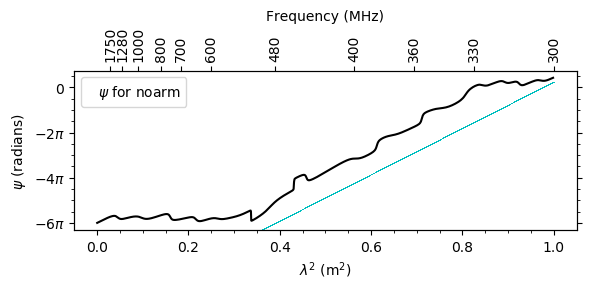

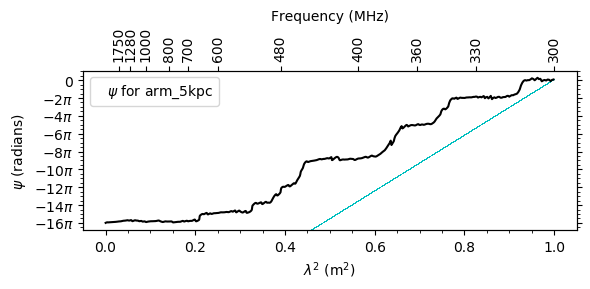

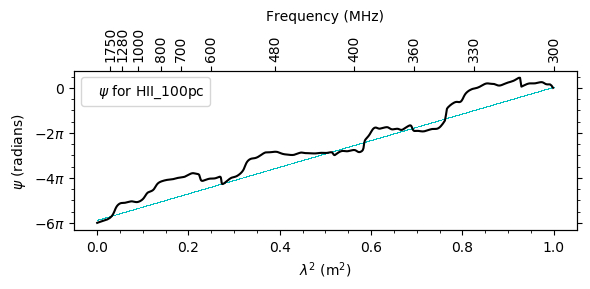

In [231]:
for m in models:
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(m['input']['wlen']**2, np.unwrap(m['psiPbeam'][-1,:]*2)/2, 'k-',
            label='$\psi$ for {}'.format(m['input']['name']))
    ax.set_xlabel(r'$\lambda^2$ (m$^2$)')
    ax.set_ylabel(r'$\psi$ (radians)')
    #ax.set_xlim(0,1)
    #ax.set_ylim(-0.08,0.08)
    
    axtop = ax.twiny()
    axtop.set_xlim(ax.get_xlim())
    ticks = ([300,330,360,400,480,600,700,800,1000,1280,1750]*u.MHz).to(u.m, equivalencies=u.spectral())
    axtop.set_xticks((ticks**2).value)
    axtop.set_xticks((ticks**2).value, minor=True)
    labels=['{:.0f}'.format(x) for x in np.sqrt(axtop.get_xticks()*u.m**2).to(u.MHz, equivalencies=u.spectral()).value]
    axtop.set_xticklabels(labels)
    axtop.set_xlabel(r'Frequency (MHz)')
    for tick in axtop.get_xticklabels():
        tick.set_rotation(90)
    ylim = ax.get_ylim()
    
    ll = np.arange(0,1,1./10000)*u.m**2
    rm = np.mean(m['phi'], axis=0)[-1]
    rml2 = np.mean(m['phi'], axis=0)[-1]*ll / 2

    ax.plot(ll, rm*ll/2 - rm*ll[-1]/2 + (m['psiPbeam'][-1,:]/2)[0],
            'c,', zorder=-5)

#    ax.plot(m['input']['wlen']**2, 35*m['input']['wlen']**2-30*u.m**2, 'c-')
    ax.set_ylim(ylim)

    ax.yaxis.set_major_locator(MultipleLocator(2*np.pi))
    ax.yaxis.set_major_formatter(FuncFormatter(piformat))
    
    ax.legend(loc='best', handlelength=0)
    basefn = ('spectrum_QU_{}_unwrapped'.format(m['input']['name'])).replace('.','_')
    fig.tight_layout()
    fig.savefig('../figures/' + basefn + '.pdf')

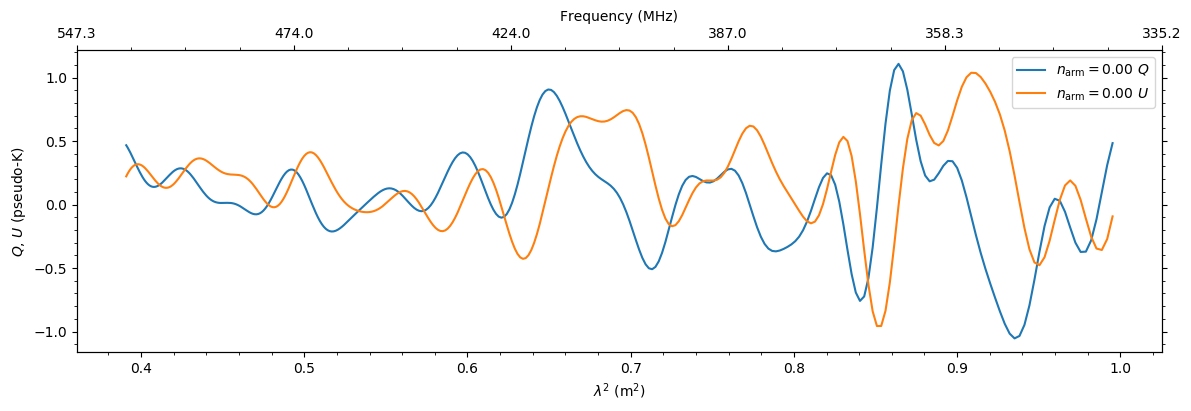

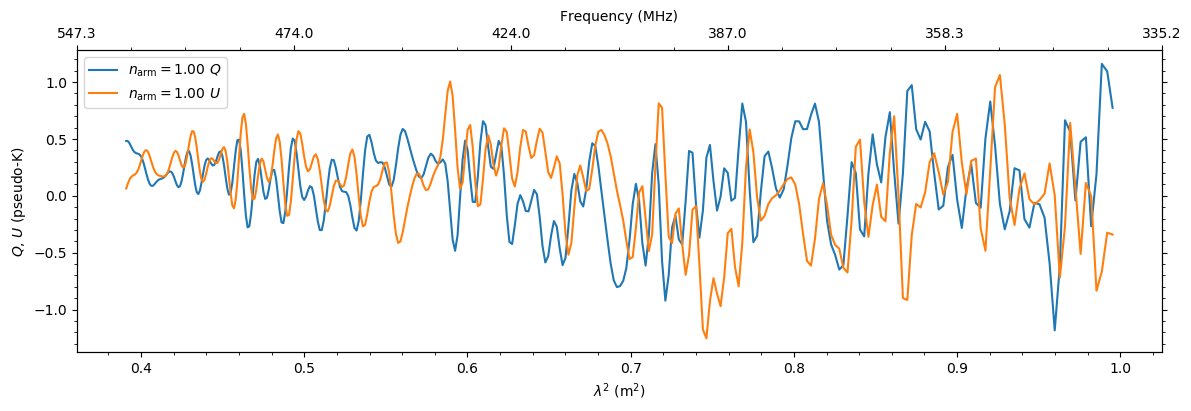

In [53]:
for m in models:
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(m['input']['wlen'][idxparkes]**2, m['Pbeam'][-1,idxparkes].real,
            label='$n_\mathrm{{arm}} = {:.2f}$ $Q$'.format(m['input']['narm'].value))
    ax.plot(m['input']['wlen'][idxparkes]**2, m['Pbeam'][-1,idxparkes].imag,
            label='$n_\mathrm{{arm}} = {:.2f}$ $U$'.format(m['input']['narm'].value))
    ax.set_xlabel(r'$\lambda^2$ (m$^2$)')
    ax.set_ylabel(r'$Q$, $U$ (pseudo-K)')
#    ax.set_ylim(-0.5,0.5)
    
    axtop = ax.twiny()
    labels=['{:.1f}'.format(x) for x in np.sqrt(ax.get_xticks()*u.m**2).to(u.MHz, equivalencies=u.spectral()).value]
    axtop.set_xticklabels(labels)
    axtop.set_xlabel(r'Frequency (MHz)')

    ax.xaxis.set_minor_locator(MultipleLocator(0.02))
    
    ax.legend(loc='best')
    #fig.savefig('../depol_figures_2018May/spectrum_QU_Parkes_narm{:.2f}.png'.format(m['input']['narm'].value))

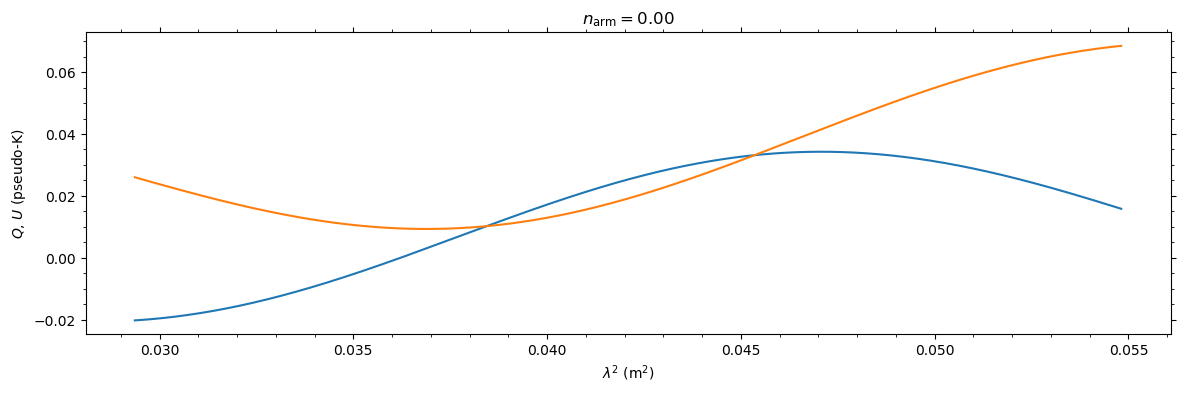

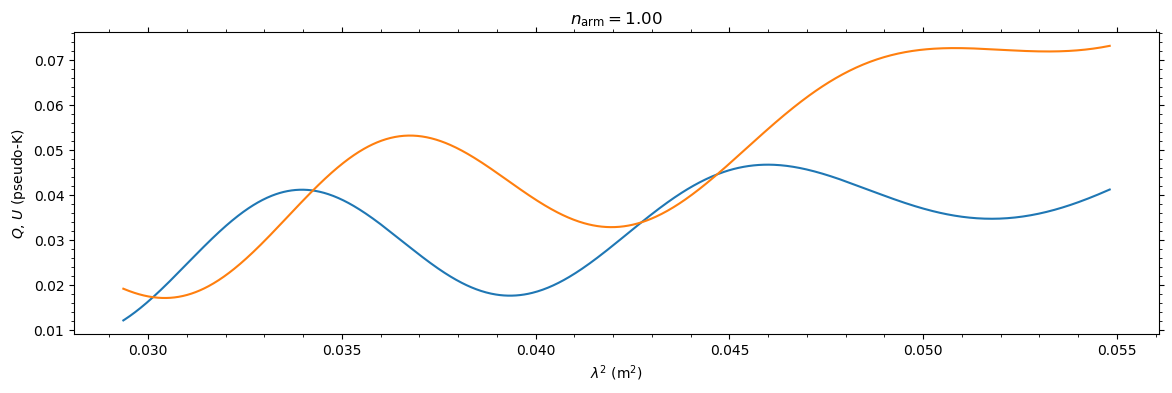

In [54]:
for m in models:
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(m['input']['wlen'][idxdrao]**2, m['Pbeam'][-1,idxdrao].real, label='$Q$')
    ax.plot(m['input']['wlen'][idxdrao]**2, m['Pbeam'][-1,idxdrao].imag, label='$U$')
    ax.set_xlabel(r'$\lambda^2$ (m$^2$)')
    ax.set_ylabel(r'$Q$, $U$ (pseudo-K)')
#    ax.set_ylim(-0.5,0.5)
    ax.xaxis.set_minor_locator(MultipleLocator(0.001))
    ax.set_title('$n_\mathrm{{arm}} = {:.2f}$'.format(m['input']['narm'].value))

    #fig.savefig('../depol_figures_2018May/spectrum_QU_DRAO_narm{:.2f}.png'.format(m['input']['narm'].value))

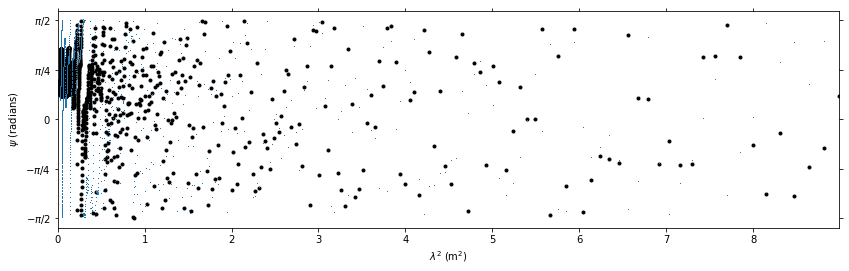

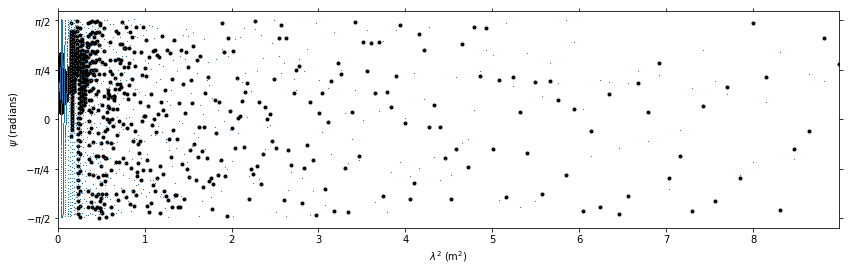

In [56]:
for m in models:
    fig, ax = plt.subplots(figsize=(14,4))
    ax.plot(m['input']['wlen']**2, m['psiPbeam'][-1,:], 'k.')
    ax.set_xlabel(r'$\lambda^2$ (m$^2$)')
    ax.set_ylabel(r'$\psi$ (radians)')
    for i in range(1):
        ax.plot(m['input']['wlen']**2, m['psiP'][i,-1,:], ',')
    ax.yaxis.set_major_locator(MultipleLocator(np.pi/4))
    ax.yaxis.set_major_formatter(FuncFormatter(piformat))
    ax.set_xlim(((2300*u.GHz).to(u.m,equivalencies=u.spectral())).value**2,
                ((100*u.MHz).to(u.m,equivalencies=u.spectral())).value**2)

Parkes Max phi 609.50 1 / m2, dphi 1.67 1 / m2
RMSynth Initializing... Complete.
DRAO Max phi 29738.94 1 / m2, dphi 39.39 1 / m2
RMSynth Initializing... Complete.
all Max phi 29738.94 1 / m2, dphi 1.03 1 / m2
RMSynth Initializing... Complete.
DRAO Max phi 29738.94 1 / m2, dphi 39.39 1 / m2
RMSynth Initializing... Complete.
all Max phi 29738.94 1 / m2, dphi 1.03 1 / m2
RMSynth Initializing... Complete.
Parkes Max phi 609.50 1 / m2, dphi 1.67 1 / m2
RMSynth Initializing... Complete.
Parkes Max phi 609.50 1 / m2, dphi 1.67 1 / m2
RMSynth Initializing... Complete.
DRAO Max phi 29738.94 1 / m2, dphi 39.39 1 / m2
RMSynth Initializing... Complete.
all Max phi 29738.94 1 / m2, dphi 1.03 1 / m2
RMSynth Initializing... Complete.
DRAO Max phi 29738.94 1 / m2, dphi 39.39 1 / m2
RMSynth Initializing... Complete.
all Max phi 29738.94 1 / m2, dphi 1.03 1 / m2
RMSynth Initializing... Complete.
Parkes Max phi 609.50 1 / m2, dphi 1.67 1 / m2
RMSynth Initializing... Complete.


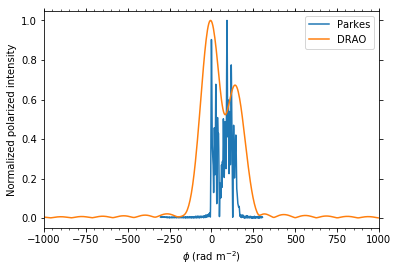

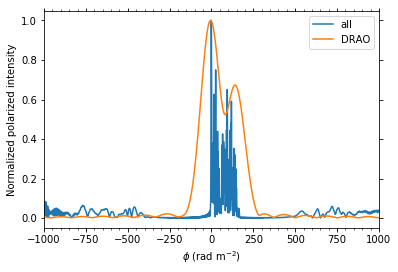

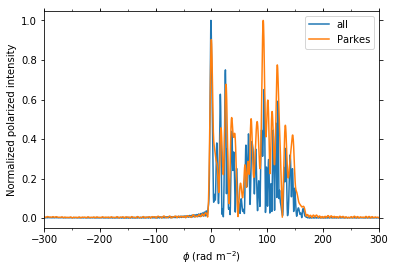

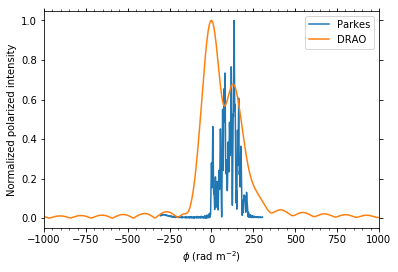

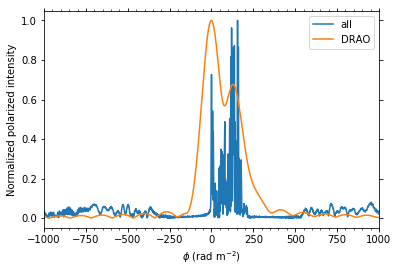

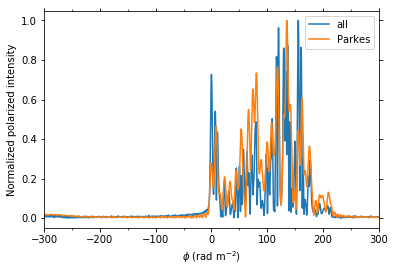

In [81]:
figdir = '../figures/'

def doplot(m, idx, label, cutoff=0.01):
    wlen = m['input']['wlen'][idx]
    nu = wlen.to(u.Hz, equivalencies=u.spectral())
    dlsq = wlen[-2]**2 - wlen[-1]**2
    maxscale = np.pi / np.min(wlen**2)
    maxphi = 1 / dlsq
    dphi = 1 / (np.max(wlen)**2 - np.min(wlen)**2)
    
    print('{} Max phi {:.2f}, dphi {:.2f}'.format(label, maxphi, dphi))
    maxphi = np.min([maxphi.value, 2000])
    dphi = np.min([dphi.value, maxphi/100.0])

    rmsynth, rmclean = calc_RM_spectrum(nu.value, m['Pbeam'][-1, idx],
                           np.arange(-2*maxphi, 2*maxphi, dphi/5), cutoff=cutoff)
    
    clean = np.abs(rmclean.clean_map)
    idxplot = np.where(np.abs(rmsynth.phi) < maxphi/2.0)
    ax.plot(rmsynth.phi[idxplot], clean[idxplot] / np.max(clean), label=label)
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.set_xlabel(r'$\phi$ (rad m$^{-2}$)')
    ax.set_ylabel(r'Normalized polarized intensity')
    ax.legend(loc='best')

for m in models:
    nu = m['input']['wlen'].to(u.Hz, equivalencies=u.spectral())
    idxdrao = np.where(np.all([nu < 1.75*u.GHz, nu > 1.28*u.GHz], axis=0))[0]
    idxparkes = np.where(np.all([nu < 480*u.MHz, nu > 300*u.MHz], axis=0))[0]
    idxlofar = np.where(np.all([nu < 231*u.MHz, nu >= 72*u.MHz], axis=0))[0]
    idxall = np.where(np.all([nu < 1.75*u.GHz, nu >= 300*u.MHz], axis=0))[0]
    
    fig, ax = plt.subplots()
    #doplot(m, idxall, 'all')
    doplot(m, idxparkes, 'Parkes', cutoff=0.001)
    doplot(m, idxdrao, 'DRAO', cutoff=0.0001)
    ax.set_xlim(-1000,1000)
    fig.savefig(figdir + 'FD_spectrum_Parkes_DRAO{:.2f}.pdf'.format(m['input']['narm'].value))

    fig, ax = plt.subplots()
    doplot(m, idxall, 'all', cutoff=0.0001)
    doplot(m, idxdrao, 'DRAO', cutoff=0.0001)
    ax.set_xlim(-1000,1000)
    fig.savefig(figdir + 'FD_spectrum_DRAO{:.2f}.pdf'.format(m['input']['narm'].value))
    
    fig, ax = plt.subplots()
    doplot(m, idxall, 'all', cutoff=0.0001)
    doplot(m, idxparkes, 'Parkes', cutoff=0.001)
    ax.set_xlim(-300,300)
    fig.savefig(figdir + 'FD_spectrum_Parkes{:.2f}.pdf'.format(m['input']['narm'].value))